# Chapter 2: A real example. Importing data and setting series

## Data Management


In this example we will show how we can import data from a csv and generate a model with several depositional series.

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In this case instead loading a geo_data object directly, we will create one. The main atributes we need to pass are:
- Extent: X min, X max, Y min, Y max, Z min, Z max
- Resolution: X,Y,Z

Additionaly we can pass the address to csv files (GeoModeller3D format) with the data.

In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000,747000,6863000,6930000,-20000, 200],[100, 100, 100],
                         path_o = os.pardir+"/input_data/a_Foliations.csv",
                         path_i = os.pardir+"/input_data/a_Points.csv")

You can visualize the points in 3D (work in progress)

Or a projection in 2D:

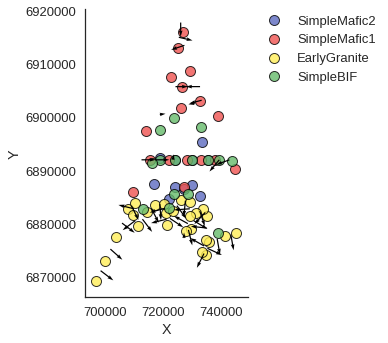

In [3]:
import matplotlib.pyplot as plt
gp.plot_data(geo_data, direction='z')


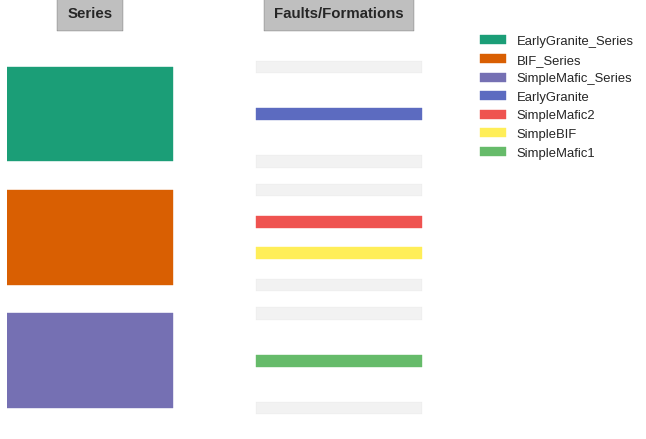

In [4]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                         "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2', 'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

## Computing the model

Now as in the previous chapter we just need to create the interpolator object and compute the model.

In [5]:
interp_data = gp.InterpolatorData(geo_data, theano_optimizer='fast_run', compile_theano=True, verbose=[])

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float32
Number of faults:  0


## Changing the points where we interpolate.

GemPy interpolation is continious in space and hence it is not bounded to a specific grid structure. The 3D points where we interpolate are stored in geo_data.grid.values. grid is an object that contains all the methods and properties related to grids (so far very ligth class). 

The easiest way to change the points to interpolate is by:
1) Creating a GridClass object with the new locations. There is a method to give custom locations
2) Set the new grid to the geo_data object
3) Update the interpolaor object (inter_data) with the new data without recompiling theano necessarilly.

In [8]:
new_grid = gp.GridClass()
res =  100

# Create a new grid object with the new resolution
new_grid.create_regular_grid_3d(geo_data.extent,[res, res, res])

# Setting the new grid to the geodata
gp.set_grid(geo_data, new_grid)

# Update the new grid
interp_data.update_interpolator(geo_data)

In [6]:
lith_block, fault_block = gp.compute_model(interp_data)

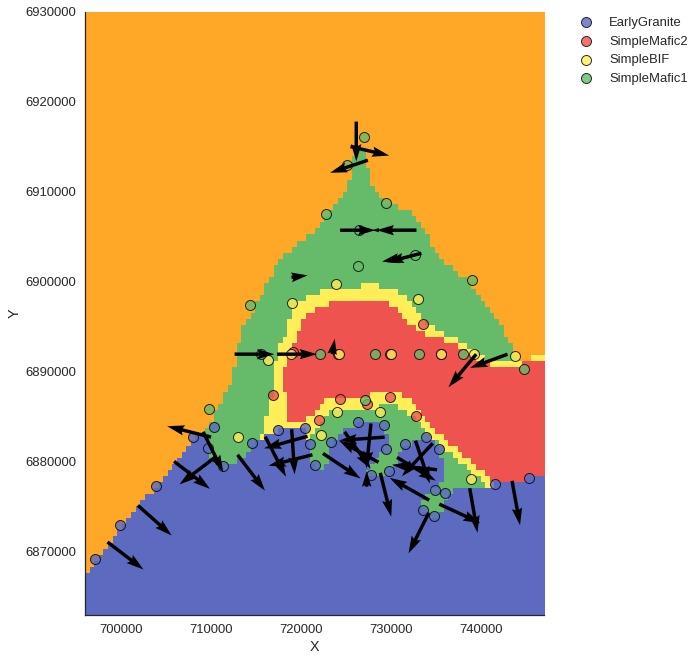

In [7]:
import matplotlib.pyplot as plt

gp.plot_section(geo_data, lith_block[0], -2, plot_data=True, direction='z')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

Now if we analyse the results we have a 3D array where the axis 0 represent the superposition of the series (potential fields). The color coding is working process yet.

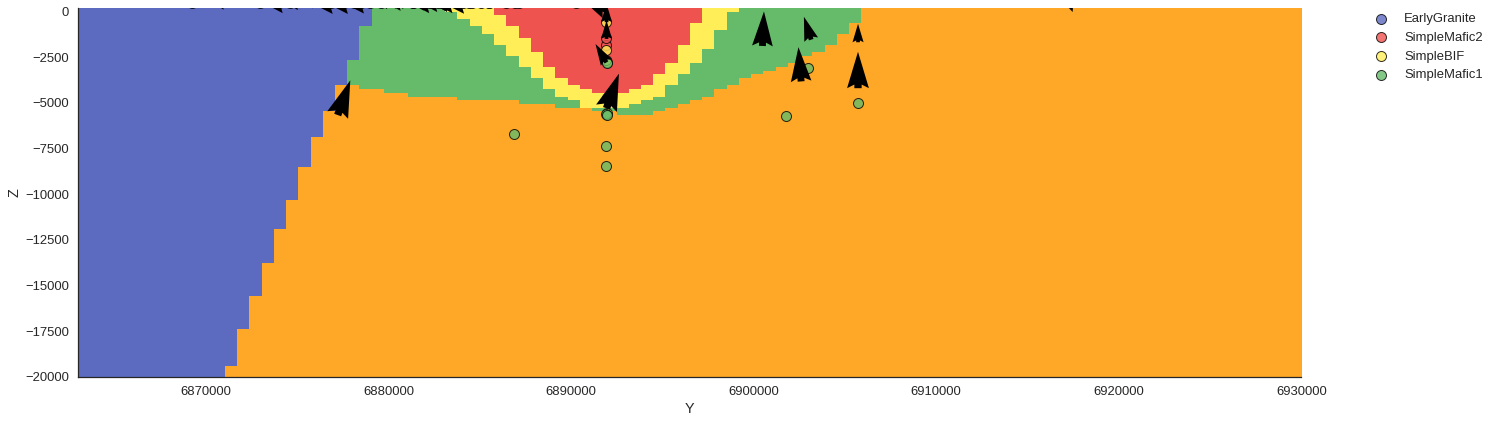

In [8]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0],50, plot_data=True, direction='x')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

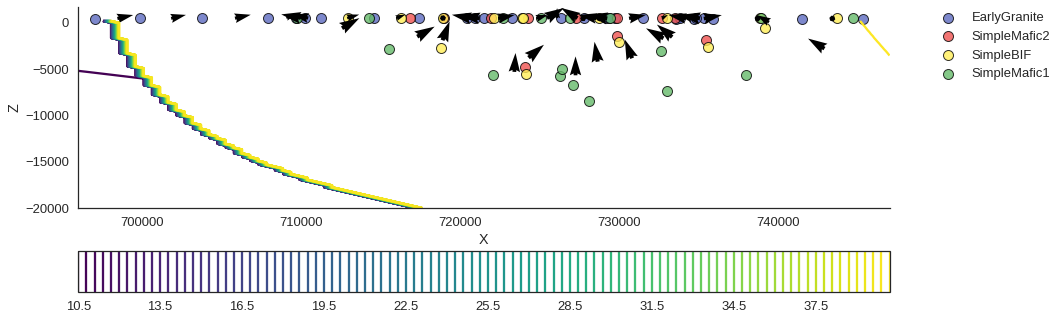

In [11]:
gp.plot_scalar_field(geo_data, lith_block[1], 11, cmap='viridis', N=100)
import matplotlib.pyplot as plt
plt.colorbar(orientation='horizontal')

And the axis 2 keeps the faults network that in this model since there is not faults does not represent anything.

Additionally with can export the blocks to vtk in order to visualize them in Paraview. We are working in visualization in place as well.

In [12]:
vertices, simplices = gp.get_surfaces(interp_data, lith_block[1], None, original_scale=False)

# np.save('ver_sand', vertices)
# np.save('sim_sand', simplices)

In [ ]:
gp.export_to_vtk(geo_data, lith_block=lith_block[0], vertices=vertices, simplices=simplices)

In [13]:
gp.plot_surfaces_3D_real_time(interp_data, vertices, simplices, alpha=1)